## Particle Analysis
### Automatic calculations & graphing
#### Code Last updated on 2025-07-15 by Yinglin Li
##### (This is meant for protease activation events, otherwise the signmoid fitting is going to be wonky)
##### (Also this version **needs** the XY file to work.)
______________________________________________________________________________
*7/14/25 - wrote code*
<br>
*7/15/25 - redid name outputs for excel + plots to include input file name*
<br>
*7/28/25 - fixed a bug with sigmoid plot fitting and added a log file input to pull out parameters*
<br>
*7/29/25 - changed sigmoid function to one used in Sigmaplot and updated bleedthrough coefficients to one saquired in live cell settings*
_____________________________________________________________________________________________

### Set user defined parameters
##### This is the ***only*** section of code that you need to modify.

In [11]:
# Set filepaths
intensity_file = r"C:\Users\yli355\Downloads\example of good particle\1ROI20I.xlsx"
Log_file = r"C:\Users\yli355\Downloads\example of good particle\TL01_1_R3D.dv.log"

# nFRET Coefficients
YFP_bleedthrough = 0.0714
mCH_bleedthrough = 0.0581

# Sigmoid fitting time (set to None to use min/max values)
lower_bound_in_minutes = None
upper_bound_in_minutes = None

### ***Do not modify*** anything below this line

In [12]:
import pandas as pd 
import numpy as np 
import os
import re
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# read in files
df1 = pd.read_excel(intensity_file, sheet_name=0, header=0)
df2 = pd.read_excel(intensity_file, sheet_name=6, header=0)
df3 = pd.read_excel(intensity_file, sheet_name=12, header=0)
log = open(Log_file).readlines()

# Get name of the file (using the intensity file, or whatever is filepath1
base_name = os.path.splitext(os.path.basename(intensity_file))[0]

# Make output file names
summary_filename = f"{base_name}_Summary.xlsx"
nFRET_fit_img = f"{base_name}_nFRET_Fit.png"
CB_fit_img = f"{base_name}_CB_Fit.png"
intensity_img = f"{base_name}_intensity.png"

# Make a folder for the outputs
filepath_out = os.path.splitext(intensity_file)[0]
os.makedirs(filepath_out, exist_ok=True)

# Get parameters from log file
temporal_resolution_line = next(line for line in log if "TLAPSE" in line)
match = re.search(r"[\d.]+", temporal_resolution_line)
Tempres = float(match.group()) if match else None

filter_lines = [line.strip() for line in log if line.strip().startswith("FILTERS")]
channel_map = {}
for line in filter_lines:
    if "488Laser,GFP" in line:
        channel_map['YFP'] = line
    elif "488Laser,mCherry" in line:
        channel_map['FRET'] = line
    elif "561Laser,mCherry" in line:
        channel_map['mCherry'] = line
ordered_labels = []
for line in filter_lines:
    for label, value in channel_map.items():
        if line == value:
            ordered_labels.append(label)
channel_numbers = {label: i + 1 for i, label in enumerate(ordered_labels)}
YFP = channel_numbers['YFP']
FRET = channel_numbers['FRET']
mCH = channel_numbers['mCherry']

def correct_shift(df):
    """
    Function to align the values into a single column for when the final track is stitched together from multiple tracks.
    Shifts all columns except the first column (the column with frame numbers) to the left, aligning each row individually.
    
    After that, shifts all rows up by one.
    Finally, drops any columns that are all NaN.

    Parameters:
    - df (pd.DataFrame): The dataframe to be shifted
    
    Returns:
    - pd.DataFrame: DataFrame with left-shifted values (NaNs on the right), rows shifted up,
                    and all-NaN columns dropped
    """
    index_col = 0  # fixed index column

    # Extract the frame number column
    preserved_col = df.iloc[:, index_col]
    data_to_shift = df.drop(df.columns[index_col], axis=1)

    # Get shift value for rows
    n_shiftup = preserved_col.count() - df.shape[0]

    # Function to left-align a single row
    def left_align_row(row):
        non_nan_values = row.dropna().tolist()
        n_nans = len(row) - len(non_nan_values)
        return pd.Series(non_nan_values + [np.nan]*n_nans, index=row.index)

    # Apply left alignment row-wise
    shifted_data = data_to_shift.apply(left_align_row, axis=1)

    # Combine back with preserved column
    result_df = pd.concat([preserved_col, shifted_data], axis=1)

    # Set preserved column as index
    result_df.set_index(result_df.columns[0], inplace=True)

    # Shift up (drop first row, reindex) but keep all rows
    result_df = result_df.shift(n_shiftup)

    # Drop columns and rows that are all NaN
    result_df = result_df.dropna(axis=1, how='all')
    result_df = result_df.dropna(axis=0, how='all')

    # Re-index rows
    result_df = result_df.reset_index(drop=True)
    
    return result_df

def rename_channels(df, YFP, FRET, mCH):
    """
    Renames the columns to 'YFP', 'FRET', and 'mCH' based on user-defined channel numbers.
 
    Parameters:
    - df (pd.DataFrame): DataFrame with at least 3 data columns (ignoring index)
    - YFP, FRET, mCH (int): Numbers assigned to each channel
    
    Returns:
    - pd.DataFrame: DataFrame with renamed columns
    """
    # Standardize the column names to A, B, C for easy mapping later on
    df.columns = ['A', 'B', 'C']

    # Build map from names based on position
    channel_labels = {YFP: 'YFP', FRET: 'FRET', mCH: 'mCH'}

    #Create list of new column names
    new_column_names = [channel_labels[i + 1] for i in range(3)]

    #Assign new column names
    df.columns = new_column_names

    return df

def sigmoid(x, y0, a, x0, b):
    return y0 + a / (1 + np.exp(-(x - x0) / b))

def fit_and_report(df, x_col, y_col, lower_bound_in_minutes=None, upper_bound_in_minutes=None):
    x_data_all = df[x_col].values
    y_data_all = df[y_col].values

    # Set fit range limits if None
    if lower_bound_in_minutes is None:
        lower_bound_in_minutes = np.min(x_data_all)
    if upper_bound_in_minutes is None:
        upper_bound_in_minutes = np.max(x_data_all)

    # Select data within fit range
    mask = (x_data_all >= lower_bound_in_minutes) & (x_data_all <= upper_bound_in_minutes)
    x_data = x_data_all[mask]
    y_data = y_data_all[mask]

    if len(x_data) == 0:
        raise ValueError("No data points found in fit range. Check lower_bound_in_minutes and upper_bound_in_minutes.")

    # Initial guess: L, k, x0, b
    initial_guess = [max(y_data) - min(y_data), 1, np.median(x_data), min(y_data)]

    # Allow k to be negative for decreasing sigmoid
    bounds = (
        [0, -5, min(x_data), min(y_data) - 0.5 * abs(min(y_data))],
        [1.5 * (max(y_data) - min(y_data)), 5, max(x_data), max(y_data) + 0.5 * abs(max(y_data))]
    )

    try:
        popt, _ = curve_fit(sigmoid, x_data, y_data, p0=initial_guess, bounds=bounds)
        L, k, x0, b = popt

        # Predict over full x range
        y_pred_all = sigmoid(x_data_all, *popt)
        residuals_all = y_data_all - y_pred_all
        mse = mean_squared_error(y_data, sigmoid(x_data, *popt))

        def calc_x_for_y(y_target):
            return x0 - (1 / k) * np.log((L / (y_target - b)) - 1)

        ec10 = calc_x_for_y(b + 0.1 * L)
        ec90 = calc_x_for_y(b + 0.9 * L)
        pr_duration = abs(ec90 - ec10)

        print(f"\n< {y_col} >")
        print(f"Fitting range: {lower_bound_in_minutes} to {upper_bound_in_minutes}")
        print(f"PR duration (ec90 - ec10): {pr_duration:.3f}")
        print(f"Mean Squared Error (fit range): {mse:.5f}\n")

    except Exception as e:
        print(f"\n< {y_col} >")
        print(f"Sigmoid fit failed for range {lower_bound_in_minutes} to {upper_bound_in_minutes}: {e}")
        print("Filling predicted/residuals with NaN.\n")

        y_pred_all = np.full_like(x_data_all, np.nan)
        residuals_all = np.full_like(x_data_all, np.nan)
        ec10 = ec90 = pr_duration = mse = np.nan

    results_df = pd.DataFrame({
        x_col: x_data_all,
        'Predicted': y_pred_all,
        'Residual': residuals_all
    })

    metrics_df = pd.DataFrame({
        'ec10': [ec10],
        'ec90': [ec90],
        'PR duration': [pr_duration],
        'MSE': [mse]
    })

    return results_df, metrics_df


df = pd.concat([correct_shift(d) for d in [df1, df2, df3]], axis=1)

df = rename_channels(df, YFP, FRET, mCH)

df['Time (sec)'] = df.index * Tempres
df['Time (min)'] = df.index * Tempres / 60
df['nFRET'] = (df['FRET'] - (YFP_bleedthrough * df['YFP']) - (mCH_bleedthrough * df['mCH'])) / df['mCH']
df['CB'] = df['YFP'] / (df['YFP'] + df['mCH'])

df = df.iloc[:, [3,4,0,2,1,5,6]]  

results_nFRET, metrics_nFRET = fit_and_report(df, 'Time (min)', 'nFRET', lower_bound_in_minutes=lower_bound_in_minutes, upper_bound_in_minutes=upper_bound_in_minutes)
results_CB, metrics_CB = fit_and_report(df, 'Time (min)', 'CB', lower_bound_in_minutes=lower_bound_in_minutes, upper_bound_in_minutes=upper_bound_in_minutes)
# Note: You want the lowest mean squared error possible

columns_to_drop = [
    'predicted nFRET', 'residual nFRET',
    'predicted CB', 'residual CB'
]

df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

results_nFRET = results_nFRET.drop(columns=['Time (min)'], errors='ignore')
results_nFRET = results_nFRET.rename(columns={
    'Predicted': 'predicted nFRET',
    'Residual': 'residual nFRET'
})

results_CB = results_CB.drop(columns=['Time (min)'], errors='ignore')
results_CB = results_CB.rename(columns={
    'Predicted': 'predicted CB',
    'Residual': 'residual CB'
})

df = pd.concat([df, results_nFRET, results_CB], axis=1)

metrics_nFRET.index = ['nFRET']
metrics_CB.index = ['CB']
kinetics = pd.concat([metrics_nFRET, metrics_CB])

# Save output
filepath = os.path.join(filepath_out, f"{base_name}_Summary.xlsx")

with pd.ExcelWriter(filepath) as writer:
    df.to_excel(writer, sheet_name='Summary', index=True)
    kinetics.to_excel(writer, sheet_name='Kinetics', index=True)


< nFRET >
Fitting range: 0.0 to 68.25
PR duration (ec90 - ec10): 2.077
Mean Squared Error (fit range): 0.02963


< CB >
Fitting range: 0.0 to 68.25
PR duration (ec90 - ec10): 4.614
Mean Squared Error (fit range): 0.00391



#### Graphs

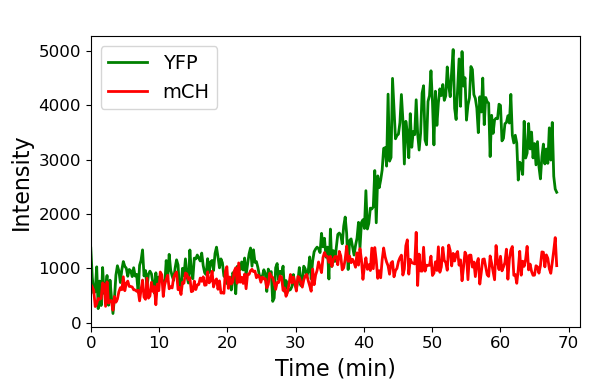

In [13]:
# Intensity plot
color_YFP = 'green' 
color_mCH = 'red'  

plt.figure(figsize=(6,4))
plt.plot(df['Time (min)'], df['YFP'], label='YFP', color=color_YFP, linewidth=2)
plt.plot(df['Time (min)'], df['mCH'], label='mCH', color=color_mCH, linewidth=2)

plt.xlabel('Time (min)', fontsize=16)       # X-axis label size
plt.ylabel('Intensity', fontsize=16)  # Y-axis label size
plt.title(' ', fontsize=16)       # Title size
plt.legend(fontsize=14)                      # Legend text size
plt.tick_params(axis='both', which='major', labelsize=12)  # Tick labels size

plt.xlim(left=0)
plt.grid(False)
plt.tight_layout()
save_path = os.path.join(filepath_out, f"{base_name}_intensity.png")
plt.savefig(save_path, dpi=300)
plt.show()

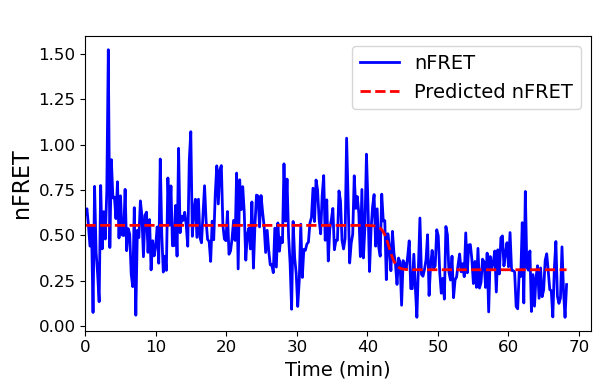

In [14]:
# Sigmoid fit of nFRET
plt.figure(figsize=(6,4))
plt.plot(df['Time (min)'], df['nFRET'], label='nFRET', color='blue', linewidth=2)
plt.plot(df['Time (min)'], df['predicted nFRET'], label='Predicted nFRET', color='red', linewidth=2, linestyle='--')

plt.xlabel('Time (min)', fontsize=14)
plt.ylabel('nFRET', fontsize=16)
plt.title(' ', fontsize=16)
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlim(left=0) # can redo to left=100 to start at min=100, or xlim(10,20) to only plot 10 to 20 min
plt.grid(False)
plt.tight_layout()
save_path = os.path.join(filepath_out, f"{base_name}_nFRET_Fit.png")
plt.savefig(save_path, dpi=300)
plt.show()

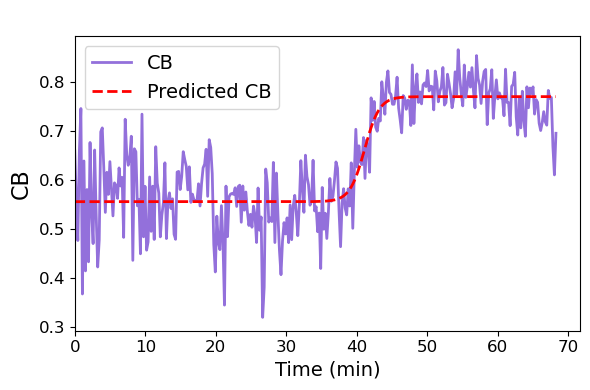

In [15]:
# Sigmoid fit of CB
plt.figure(figsize=(6,4))
plt.plot(df['Time (min)'], df['CB'], label='CB', color='mediumpurple', linewidth=2)
plt.plot(df['Time (min)'], df['predicted CB'], label='Predicted CB', color='red', linewidth=2, linestyle='--')

plt.xlabel('Time (min)', fontsize=14)
plt.ylabel('CB', fontsize=16)
plt.title(' ', fontsize=16)
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlim(left=0) # can redo to left=100 to start at min=100, or xlim(10,20) to only plot 10 to 20 min
plt.grid(False)
plt.tight_layout()
save_path = os.path.join(filepath_out, f"{base_name}_CB_Fit.png")
plt.savefig(save_path, dpi=300)
plt.show()